In [157]:
# Import libraries

import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [158]:
# Load data
df = pd.read_csv('SMDG_results.csv')

# Remove rows with missing values
df = df.dropna()

# Remove rows where glaucoma is not 0 or 1
# df = df[df['glaucoma'].isin([0, 1])]

# Remove unnecesary columns
keep = ['filename', 'glaucoma'] + [col for col in df.columns if 'pcdr_' in col]
df = df[keep]

# Cap pcdr_ values to 1
df[df.iloc[:, 2:] > 1] = 1

# Keep only rows that have pcdr_ values (lb, ub]
lb = 0 ; ub = 1
df = df[(df.iloc[:, 2:] <= lb).any(axis=1).__invert__() & (df.iloc[:, 2:] > ub).any(axis=1).__invert__()]

# Remove rows with all pcdr_ values equal to 1
df = df[(df.iloc[:, 2:] == 1).all(axis=1).__invert__()]

print('Images suitable for analysis:', df.shape[0])
print('Glaucoma:', (df['glaucoma'] == 1).sum())
print('Non glaucoma:', (df['glaucoma'] == 0).sum())
print('Grey-zone glaucoma:', (df['glaucoma'] == -1).sum())

Images suitable for analysis: 7785
Glaucoma: 2813
Non glaucoma: 4939
Grey-zone glaucoma: 33


**Disclaimer**

- Disc, cup and fovea segmentations are done using segmentation CNNs. Very useful for large batches of data but can generate some weird segmentations, especially in low quality fundus images.

**Excluding rules**

- All pCDR values == 1: ellipses fitted to cup and disc segmentations are equal or almost equal.
  
- pCDR values very low: generally caused by the disc segmentation not being great (disc surrounding tissue, pathology near disc, disc edge barely visible...).
  
- pCDR values > 1: disc and cup ellipses are very very close together and, mathematically, the calculation of the intersection points leads to the cup_points going over the disc_points.

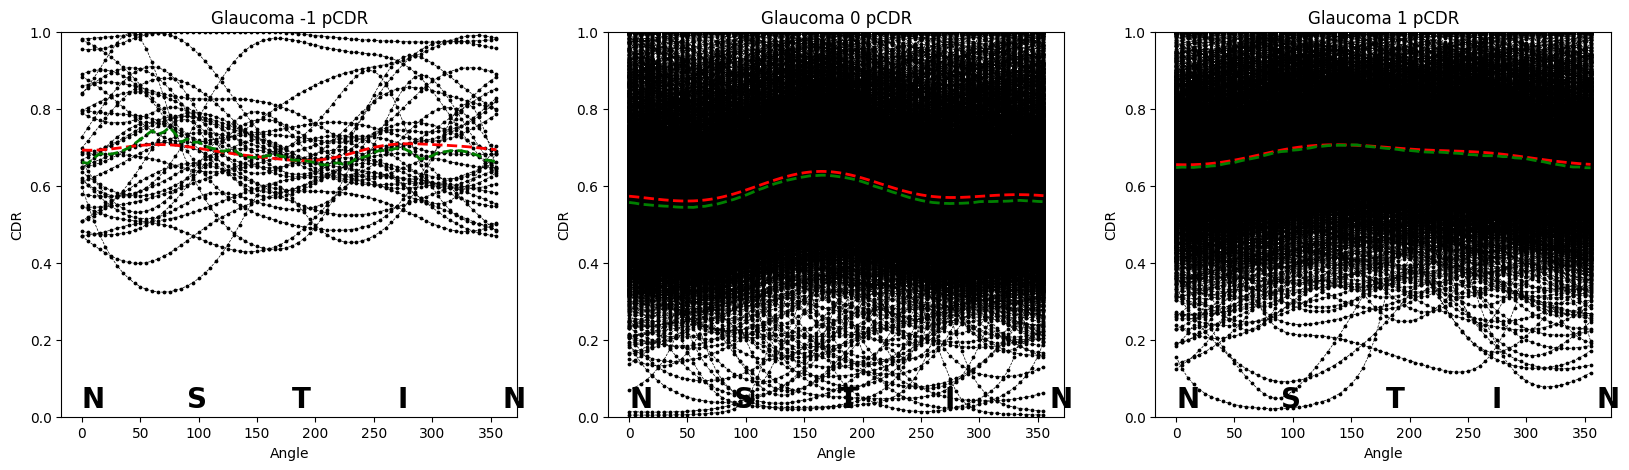

In [159]:
# Group by glaucoma status
df_grouped = df.groupby('glaucoma')

# Plot pcdr values
plt.figure(figsize=(20, 5))
for i, (name, group) in enumerate(df_grouped):
    plt.subplot(1, 3, i + 1)
    group = group.drop(['filename', 'glaucoma'], axis=1)
    cdr = group.values.T
    angles = [int(col.split('_')[1]) for col in group.columns if col.startswith('pcdr_')]
    angles = np.tile(angles, (cdr.shape[1], 1)).T # Make angles same shape as cdr for plotting
    plt.plot(angles, cdr, 'k--', linewidth=0.5)
    plt.scatter(angles, cdr, s=3, c='k')
    
    # Plot mean and median
    mean_cdr = np.mean(cdr, axis=1)
    median_cdr = np.median(cdr, axis=1)
    plt.plot(angles[:, 0], mean_cdr, 'r--', linewidth=2)
    plt.plot(angles[:, 0], median_cdr, 'g--', linewidth=2)
    
    # Overlay N S T I N labels on top of the X axis
    angle = [0, 90, 180, 270, 360]
    quadrant = ['N', 'S', 'T', 'I', 'N']
    for a, q in zip(angle, quadrant):
        plt.text(a, 0.025, q, fontsize=20, color='k', fontweight='bold')
    
    plt.title(f'Glaucoma {name} pCDR')
    plt.xlabel('Angle')
    plt.ylabel('CDR')
    plt.ylim(0, 1)
    
plt.show()

/tmp/ipykernel_525130/3780969042.py:11: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(mahal.diagonal())


Text(0.5, 1.0, 'Mahalanobis distance to grey-zone glaucoma group')

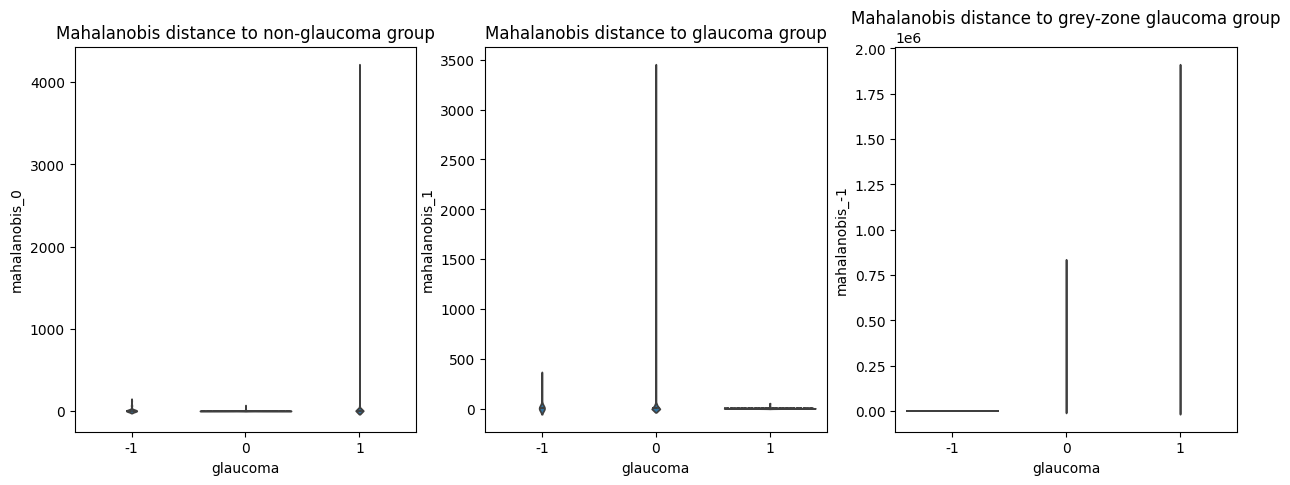

In [174]:
# Define method to calculate Mahalanobis distance
def mahalanobis(data, cov):
    """Compute the Mahalanobis Distance between each row of x and the data
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = data - np.mean(data)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return np.sqrt(mahal.diagonal())

# Calculate Mahalanobis distance for each group
cov_matrices = {}
for name, group in df_grouped:
    # Covariance matrix
    cov = np.cov(group.iloc[:, 2:].values.T)
    # Add covariance matrix to dictionary
    cov_matrices.update({name: cov})

# Calculate Mahalanobis distance for each cov matrix
df2 = df.copy()
for k, v in cov_matrices.items():
    col_name = f'mahalanobis_{k}'
    df2[col_name] = mahalanobis(data=df.iloc[:, 2:], cov=v)
    
# Remove rows with Mahalanobis distance NaN or Inf
df2 = df2.replace([np.inf, -np.inf], np.nan).dropna()

# Plot Mahalanobis distances as violin plots
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.violinplot(data=df2, x='glaucoma', y='mahalanobis_0', inner='quartile')
plt.yscale('log')
plt.title('Mahalanobis distance to non-glaucoma group')

plt.subplot(1, 3, 2)
sns.violinplot(data=df2, x='glaucoma', y='mahalanobis_1', inner='quartile')
plt.yscale('log')
plt.title('Mahalanobis distance to glaucoma group')

plt.subplot(1, 3, 3)
sns.violinplot(data=df2, x='glaucoma', y='mahalanobis_-1', inner='quartile')
plt.yscale('log')
plt.title('Mahalanobis distance to grey-zone glaucoma group')